In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from patchify import patchify, unpatchify
from copy import deepcopy
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from src.data.constants import MAX_PIXEL_VALUE
from src.data.datamodules import SurfaceVolumeDatamodule
from src.utils.utils import PredictionTargetPreviewAgg, read_data, pad_divisible_2d, rotate_limit_to_min_scale
from src.data.datasets import InMemorySurfaceVolumeDataset, OnlineSurfaceVolumeDataset
from src.data.transforms import (
    CenterCropVolume, 
    ToCHWD, 
    ToWritable, 
    RotateZ, 
    RandomCropVolumeInside2dMask, 
    ResizeVolume,
)

# Show sample images

In [ ]:
volume_00 = Image.fromarray(
    (cv2.imread(
        '/workspace/data/fragments_downscaled_2/train/3/surface_volume/00.tif',
        cv2.IMREAD_UNCHANGED
    ) // 256).astype(np.uint8)
)
ir_img = cv2.imread(
    '/workspace/data/fragments_downscaled_2/train/3/ir.png',
    cv2.IMREAD_GRAYSCALE
)
scroll_mask = cv2.imread(
    '/workspace/data/fragments_downscaled_2/train/3/mask.png',
    cv2.IMREAD_GRAYSCALE
)
ink_mask = cv2.imread(
    '/workspace/data/fragments_downscaled_2/train/3/inklabels.png',
    cv2.IMREAD_GRAYSCALE
)

In [ ]:
volume_00.size, ir_img.size, scroll_mask.size, ink_mask.size

In [ ]:
ir_img = Image.open('/workspace/data/fragments/train/1/ir.png')
ir_img.size

In [ ]:
volume_00

In [ ]:
np.array(volume_00).dtype

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()
for i, img in enumerate([volume_00, ir_img, scroll_mask, ink_mask]):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail((512, 512))
    axes[i].imshow(img_thumbnail, cmap='gray')

In [ ]:
crop_size = 256
center_x, center_y = 1000, 1000
crop_bbox = (center_x, center_y, center_x + crop_size, center_y + crop_size)

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()
for i, img in enumerate([volume_00, ir_img, scroll_mask, ink_mask]):
    img_thumbnail = img.crop(crop_bbox)
    axes[i].imshow(img_thumbnail, cmap='gray')

# Patchify

In [ ]:
scroll_mask.shape

In [ ]:
plt.imshow(scroll_mask, cmap='gray')

In [ ]:
# pad to be divisible by 256
scroll_mask = np.pad(
    scroll_mask, 
    (
        (0, 256 - scroll_mask.shape[0] % 256), 
        (0, 256 - scroll_mask.shape[1] % 256)
    ), 
    'constant', 
    constant_values=0
)

In [ ]:
plt.imshow(scroll_mask, cmap='gray')

In [ ]:
scroll_mask.shape

In [ ]:
scroll_mask_patchified = patchify(scroll_mask, (256, 256), step=128)
scroll_mask_patchified.shape

In [ ]:
fig, axes = plt.subplots(
    scroll_mask_patchified.shape[0], 
    scroll_mask_patchified.shape[1], 
    figsize=(scroll_mask_patchified.shape[0], scroll_mask_patchified.shape[1])
)
for i in range(scroll_mask_patchified.shape[0]):
    for j in range(scroll_mask_patchified.shape[1]):
        axes[i, j].imshow(scroll_mask_patchified[i, j], vmin=0, vmax=255, cmap='gray')
        axes[i, j].tick_params(
            axis='x', 
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )
        axes[i, j].tick_params(
            axis='y', 
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )
fig.tight_layout()

In [ ]:
scroll_mask_unpatchified = unpatchify(scroll_mask_patchified, scroll_mask.shape)
scroll_mask_unpatchified.shape

In [ ]:
plt.imshow(scroll_mask_unpatchified, cmap='gray')

# Test datamodule

In [ ]:
datamodule = SurfaceVolumeDatamodule(
    surface_volume_dirs=[
        '/workspace/data/fragments/train/1',
        '/workspace/data/fragments/train/2',
        '/workspace/data/fragments/train/3',
    ],
    surface_volume_dirs_test=None,	
    val_dir_indices=[2],
    crop_size=512,
    crop_size_z=60,
    img_size=256,
    img_size_z=64,
    batch_size=2,
    num_workers=10,
    pin_memory=False,
    prefetch_factor=2,
    persistent_workers=True,
)
datamodule.setup()

In [ ]:
dataloader = datamodule.train_dataloader()

In [ ]:
%%timeit -n 10
for batch in tqdm(dataloader):
    pass

### Plots

In [ ]:
dataloader = datamodule.train_dataloader()
batch = next(iter(dataloader))

volume_00s, ir_imgs, scroll_masks, ink_masks = batch['image'], batch['mask_0'], batch['mask_1'], batch['mask_2']

for i in range(volume_00s.shape[0]):
    volume_00, ir_img, scroll_mask, ink_mask = \
        volume_00s[i].cpu().numpy()[0, :, :, 31], \
        ir_imgs[i].cpu().numpy(), \
        scroll_masks[i].cpu().numpy(), \
        ink_masks[i].cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()

    for i, img in enumerate([volume_00, ir_img, scroll_mask, ink_mask]):
        vmin = -1 if i == 0 else 0
        axes[i].imshow(img, vmin=vmin, vmax=1, cmap='gray')

In [ ]:
dataloader.dataset[0][0].shape

In [ ]:
dataloader = datamodule.val_dataloader()
batch = next(iter(dataloader))

volume_00s, ir_imgs, scroll_masks, ink_masks = batch['image'], batch['mask_0'], batch['mask_1'], batch['mask_2']

for i in range(volume_00s.shape[0]):
    volume_00, ir_img, scroll_mask, ink_mask = \
        volume_00s[i].cpu().numpy()[0, :, :, 31], \
        ir_imgs[i].cpu().numpy(), \
        scroll_masks[i].cpu().numpy(), \
        ink_masks[i].cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()

    for i, img in enumerate([volume_00, ir_img, scroll_mask, ink_mask]):
        print(scroll_mask.shape, scroll_mask.sum())
        vmin = -1 if i == 0 else 0
        axes[i].imshow(img, vmin=vmin, vmax=1, cmap='gray')

In [ ]:
len(dataloader.dataset), dataloader.dataset[0]['image'].shape

### `PredictionTargetPreviewAgg` test

In [ ]:
dataloader = datamodule.val_dataloader()

In [ ]:
for batch in tqdm(dataloader):
    pass

In [ ]:
scroll_mask.shape

In [ ]:
plt.imshow(scroll_mask, cmap='gray')

In [ ]:
plt.imshow(pad_divisible_2d(scroll_mask, (256, 256)), cmap='gray')

In [ ]:
surface_volume_dirs=[
    '/workspace/data/fragments_downscaled_2/train/1',
    '/workspace/data/fragments_downscaled_2/train/2',
    '/workspace/data/fragments_downscaled_2/train/3',
]
val_dir_indices = [2]
crop_size = 256
crop_size_z = 64
val_transform = A.Compose(
    [
        ToWritable(),  # TODO: remove this
        CenterCropVolume(
            height=crop_size, 
            width=crop_size,
            depth=crop_size_z,
            always_apply=True,
        ),
        A.Normalize(
            max_pixel_value=65536,
            mean=sum((0.485, 0.456, 0.406)) / 3,
            std=sum((0.229, 0.224, 0.225)) / 3,
            always_apply=True,
        ),
        ToTensorV2(),
        ToCHWD(always_apply=True),
    ],
)

val_surface_volume_dirs = [
    d for i, d in enumerate(surface_volume_dirs)
    if i in val_dir_indices
]
volumes, scroll_masks, ir_images, ink_masks = \
    read_data(val_surface_volume_dirs)
val_dataset = InMemorySurfaceVolumeDataset(
    volumes=volumes, 
    scroll_masks=scroll_masks, 
    pathes=val_surface_volume_dirs,
    ir_images=ir_images, 
    ink_masks=ink_masks,
    transform=val_transform,
    patch_size=crop_size,  # patch without overlap
    n_repeat=1,  # no repeats for validation
)

In [ ]:
volumes[0].shape

In [ ]:
agg = PredictionTargetPreviewAgg(preview_downscale=8)
for i in tqdm(range(len(val_dataset))):
    batch = val_dataset[i]
    type(batch['shape_patches'])
    agg.update(
        torch.tensor(batch['image'][..., 0]).unsqueeze(0),
        torch.tensor(batch['masks'][0]).unsqueeze(0), 
        torch.tensor(batch['masks'][2]).unsqueeze(0), 
        pathes=[batch['path']],
        indices=torch.tensor(batch['indices']).unsqueeze(0), 
        shape_patches=torch.tensor(batch['shape_patches']).unsqueeze(0),
    )

In [ ]:
captions, images = agg.compute()
h_patch, w_patch = agg.previews[f'target_train/3'].shape[:2]

In [ ]:
indices_unique = set()
for i in tqdm(range(len(val_dataset))):
    item = val_dataset[i]
    i, j = item['indices']
    if (i, j) not in indices_unique:
        indices_unique.add((i, j))
    else:
        print(i, j)

In [ ]:
mask = np.zeros((h_patch, w_patch))
for k in tqdm(range(len(val_dataset))):
    item = val_dataset[k]
    j, i = item['indices']
    mask[i, j] = 1
fig, axes = plt.subplots(1, 1, figsize=(w_patch, h_patch))
axes.imshow(mask, cmap='gray')
# colorbar
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cax.imshow(np.array([[0, 1]]), cmap='gray')

In [ ]:
val_dataset[0]['masks'][0]

In [ ]:
fig, axes = plt.subplots(h_patch, w_patch, figsize=(w_patch, h_patch))
for k in tqdm(range(len(val_dataset))):
    item = val_dataset[k]
    j, i = item['indices']
    axes[i, j].imshow(item['masks'][0], cmap='gray', vmin=0, vmax=1)
    axes[i, j].tick_params(
        axis='x', 
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )
    axes[i, j].tick_params(
        axis='y', 
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

In [ ]:
agg = PredictionTargetPreviewAgg(preview_downscale=8)
for batch in tqdm(dataloader):
    agg.update(
        batch['image'][..., 0],
        batch['mask_0'], 
        batch['mask_2'], 
        pathes=batch['path'],
        indices=batch['indices'], 
        shape_patches=batch['shape_patches'],
    )

In [ ]:
captions, images = agg.compute()
h_patch, w_patch = agg.previews[f'target_train/3'].shape[:2]

In [ ]:
fig, axes = plt.subplots(h_patch, w_patch, figsize=(w_patch, h_patch))
for batch in tqdm(dataloader):
    for k in range(len(batch['indices'])):
        j, i = batch['indices'][k].tolist()
        axes[i, j].imshow(batch['mask_0'][k], cmap='gray', vmin=0, vmax=1)
        axes[i, j].tick_params(
            axis='x', 
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )
        axes[i, j].tick_params(
            axis='y', 
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (caption, image, ax) in enumerate(zip(captions, images, axes)):
    ax.imshow(image, vmin=0, vmax=255, cmap='gray')
    ax.set_title(caption)
    ax.axis('off')

# Mean and std

In [ ]:
surface_volume_dirs=[
    '/workspace/data/fragments_downscaled_2/train/1',
    '/workspace/data/fragments_downscaled_2/train/2',
    '/workspace/data/fragments_downscaled_2/train/3',
]
val_dir_indices = [2]
crop_size = None
crop_size_z = 64
val_transform = None

volumes, scroll_masks, ir_images, ink_masks = \
    read_data(surface_volume_dirs)
dataset = InMemorySurfaceVolumeDataset(
    volumes=volumes, 
    scroll_masks=scroll_masks, 
    pathes=surface_volume_dirs,
    ir_images=ir_images, 
    ink_masks=ink_masks,
    transform=val_transform,
    patch_size=crop_size,  # patch without overlap
    n_repeat=1,  # no repeats for validation
)

In [ ]:
for volume in volumes:
    print(volume.shape)

Two-pass mean and std computation

In [ ]:
# mean, std across all volumes
N_SLICES = 65
MAX_PIXEL_VALUE = 65536
sum_, n = 0, 0
for volume, scroll_mask in zip(volumes, scroll_masks):
    scroll_mask = scroll_mask > 0
    sum_ += (volume[scroll_mask] / MAX_PIXEL_VALUE).sum()
    n += (scroll_mask.sum() * N_SLICES)
mean = sum_ / n

sum_sq = 0
for volume, scroll_mask in zip(volumes, scroll_masks):
    scroll_mask = scroll_mask > 0
    sum_sq += (((volume[scroll_mask] / MAX_PIXEL_VALUE - mean)) ** 2).sum()
std = np.sqrt(sum_sq / n)

mean, std

One-pass mean and std computation

In [ ]:
# mean, std across all volumes
N_SLICES = 65
MAX_PIXEL_VALUE = 65536
sums, sums_sq, ns = [], [], []
for volume, scroll_mask in zip(volumes, scroll_masks):
    scroll_mask = scroll_mask > 0
    sums.append((volume[scroll_mask] / MAX_PIXEL_VALUE).sum())
    sums_sq.append(((volume[scroll_mask] / MAX_PIXEL_VALUE) ** 2).sum())
    ns.append(scroll_mask.sum() * N_SLICES)
mean = sum(sums) / sum(ns)

sum_sq = 0
for sum_, sum_sq_, n in zip(sums, sums_sq, ns):
    scroll_mask = scroll_mask > 0
    sum_sq += (sum_sq_ - 2 * sum_ * mean + mean ** 2 * n)
std = np.sqrt(sum_sq / sum(ns))

mean, std

Verify by costlier and simplier stack + mean / std computation

In [ ]:
# mean, std across all volumes
MAX_PIXEL_VALUE = 65536
total_volume = []
for volume, scroll_mask in zip(volumes, scroll_masks):
    scroll_mask = scroll_mask > 0
    total_volume.append(volume[scroll_mask] / MAX_PIXEL_VALUE)

total_volume = np.concatenate(total_volume, axis=0).reshape(-1)

mean = total_volume.mean()
std = total_volume.std()

mean, std

Implemented in datamodule: imagenet and by-train-dataset, controlled by `use_imagenet_stats` flag

In [ ]:
datamodule = SurfaceVolumeDatamodule(
    surface_volume_dirs=[
        '/workspace/data/fragments_downscaled_2/train/1',
        '/workspace/data/fragments_downscaled_2/train/2',
        '/workspace/data/fragments_downscaled_2/train/3',
    ],
    surface_volume_dirs_test=None,	
    val_dir_indices=[2],
    crop_size=256,
    crop_size_z=64,
    use_imagenet_stats=True,
    batch_size=2,
    num_workers=10,
    pin_memory=False,
    prefetch_factor=2,
    persistent_workers=True,
)
datamodule.setup()
datamodule.train_volume_mean, datamodule.train_volume_std

In [ ]:
datamodule = SurfaceVolumeDatamodule(
    surface_volume_dirs=[
        '/workspace/data/fragments_downscaled_2/train/1',
        '/workspace/data/fragments_downscaled_2/train/2',
        '/workspace/data/fragments_downscaled_2/train/3',
    ],
    surface_volume_dirs_test=None,	
    val_dir_indices=[2],
    crop_size=256,
    crop_size_z=64,
    use_imagenet_stats=False,
    batch_size=2,
    num_workers=10,
    pin_memory=False,
    prefetch_factor=2,
    persistent_workers=True,
)
datamodule.setup()
datamodule.train_volume_mean, datamodule.train_volume_std

In [ ]:
dataloader = datamodule.val_dataloader()

agg = PredictionTargetPreviewAgg(preview_downscale=8)
for batch in tqdm(dataloader):
    agg.update(
        batch['image'][..., 0],
        batch['mask_0'], 
        batch['mask_2'], 
        pathes=batch['path'],
        indices=batch['indices'], 
        shape_patches=batch['shape_patches'],
    )

captions, images = agg.compute()
h_patch, w_patch = agg.previews[f'target_train/3'].shape[:2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (caption, image, ax) in enumerate(zip(captions, images, axes)):
    ax.imshow(image, vmin=0, vmax=255, cmap='gray')
    ax.set_title(caption)
    ax.axis('off')

# Positives and negatives counts

In [ ]:
surface_volume_dirs=[
    '/workspace/data/fragments_downscaled_2/train/1',
    '/workspace/data/fragments_downscaled_2/train/2',
    '/workspace/data/fragments_downscaled_2/train/3',
]
val_dir_indices = [2]
crop_size = None
crop_size_z = 64
val_transform = None

volumes, scroll_masks, ir_images, ink_masks = \
    read_data(surface_volume_dirs)
dataset = InMemorySurfaceVolumeDataset(
    volumes=volumes, 
    scroll_masks=scroll_masks, 
    pathes=surface_volume_dirs,
    ir_images=ir_images, 
    ink_masks=ink_masks,
    transform=val_transform,
    patch_size=crop_size,  # patch without overlap
    n_repeat=1,  # no repeats for validation
)

In [ ]:
# n_positive, n_negative
n_positive, n_negative, n_total = 0, 0, 0
for ink_mask, scroll_mask in zip(ink_masks, scroll_masks):
    scroll_mask = scroll_mask > 0
    n_positive += (ink_mask[scroll_mask] > 0).sum()
    n_negative += (ink_mask[scroll_mask] == 0).sum()
    n_total += scroll_mask.sum()
n_positive / n_total, n_negative / n_total, n_negative / n_positive

# Transforms

### `RandomCropVolumeInside2dMask`, `RotateZ` and `CenterCropVolume`

In [3]:
surface_volume_dirs=[
    '/workspace/data/fragments_downscaled_2/train/1',
    '/workspace/data/fragments_downscaled_2/train/2',
    '/workspace/data/fragments_downscaled_2/train/3',
]
val_dir_indices = [2]

crop_size = 768
crop_size_z = 6
rotate_limit_degrees_xy = 45
rotate_limit_degrees_z = 3.0 * 768 / crop_size

eps = 0.1
rotation_scale = (
    rotate_limit_to_min_scale(rotate_limit_degrees_xy, proj=False) *
    rotate_limit_to_min_scale(rotate_limit_degrees_z, proj=True)
)
rotation_scale_z = rotate_limit_to_min_scale(rotate_limit_degrees_z, proj=True)

base_size = math.ceil(crop_size * rotation_scale + eps)
base_depth = 65
crop_size_z_pre = 65

volumes, scroll_masks, ir_images, ink_masks = \
    read_data(surface_volume_dirs, center_crop_z=crop_size_z_pre)
dataset = InMemorySurfaceVolumeDataset(
    volumes=volumes, 
    scroll_masks=scroll_masks, 
    pathes=surface_volume_dirs,
    ir_images=ir_images, 
    ink_masks=ink_masks,
    transform=None,
    patch_size=None,  # patch without overlap
)

In [4]:
(
    f'crop_size: {crop_size}, '
    f'base_size: {base_size}, '
    f'crop_size_z: {crop_size_z}, '
    f'base_depth: {base_depth}, '
    f'crop_size_z_pre: {crop_size_z_pre}'
)

'crop_size: 768, base_size: 1148, crop_size_z: 6, base_depth: 65, crop_size_z_pre: 65'

In [5]:
transform0 = CenterCropVolume(
    height=None, 
    width=None,
    depth=crop_size_z_pre,
    strict=True,
    always_apply=True,
)
transform1 = RandomCropVolumeInside2dMask(
    base_size=base_size, 
    base_depth=base_depth,
    scale=(0.5, 2.0),
    ratio=(0.9, 1.1),
    scale_z=(0.9, 1.1),
    always_apply=True,
    crop_mask_index=0,
)
transform2 = A.Rotate(p=1.0, limit=rotate_limit_degrees_xy, crop_border=True)
transform3 = RotateZ(p=1.0, limit=rotate_limit_degrees_z, crop_border=True)

In [6]:
data = dataset[0]

In [7]:
original_id, original_shape = id(data['image']), data['image'].shape
original_id, original_shape

(140471230634320, (4090, 3165, 65))

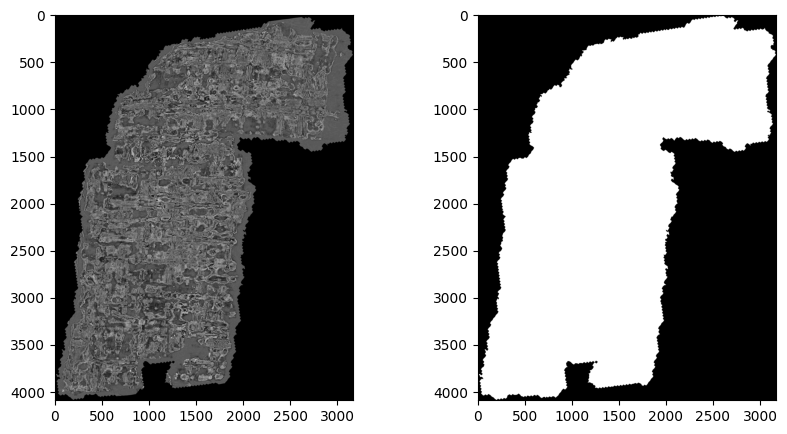

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data['image'][..., 0], cmap='gray')
axes[1].imshow(data['masks'][0], cmap='gray', vmin=0, vmax=1)

In [9]:
data0 = transform0(**data)

Ensure that `CenterCropVolume` does not change original volume

In [10]:
id(data['image']), id(data0['image']), data['image'].shape, data0['image'].shape

(140471230634320, 140471230631056, (4090, 3165, 65), (4090, 3165, 65))

In [11]:
assert id(data['image']) == original_id
assert id(data['image']) != id(data0['image'])
assert data['image'].shape == original_shape

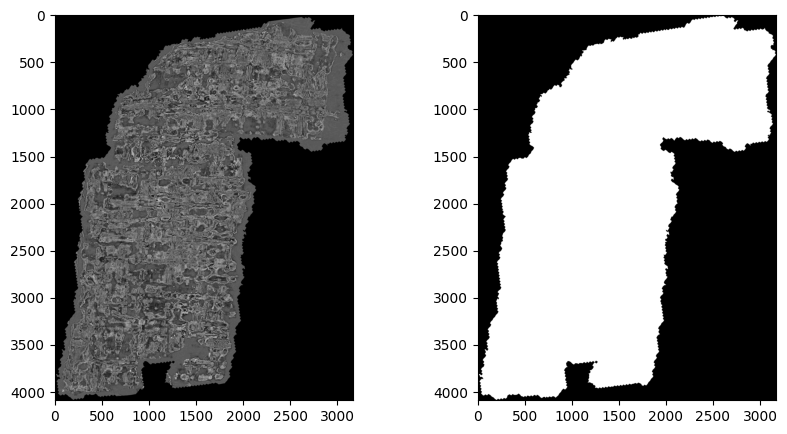

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data['image'][..., 0], cmap='gray')
axes[1].imshow(data['masks'][0], cmap='gray', vmin=0, vmax=1)

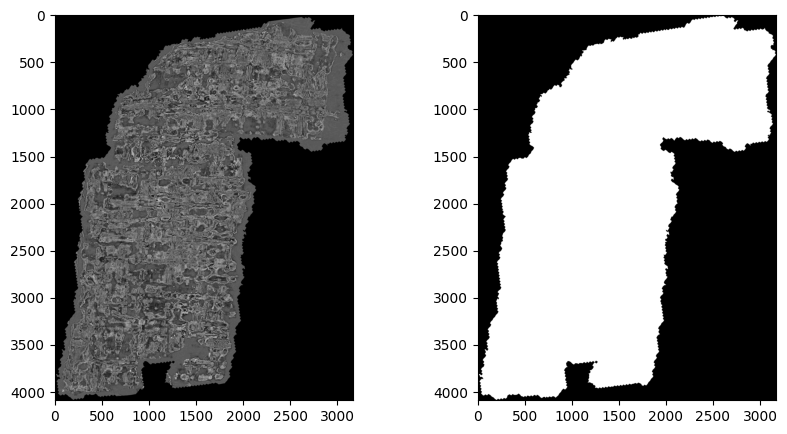

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data0['image'][..., 0], cmap='gray')
axes[1].imshow(data0['masks'][0], cmap='gray', vmin=0, vmax=1)

In [14]:
data1 = transform1(**data0)

In [15]:
id(data['image']), id(data0['image']), id(data1['image']), data['image'].shape, data0['image'].shape, data1['image'].shape

(140471230634320,
 140471230631056,
 140471202009072,
 (4090, 3165, 65),
 (4090, 3165, 65),
 (1908, 1795, 59))

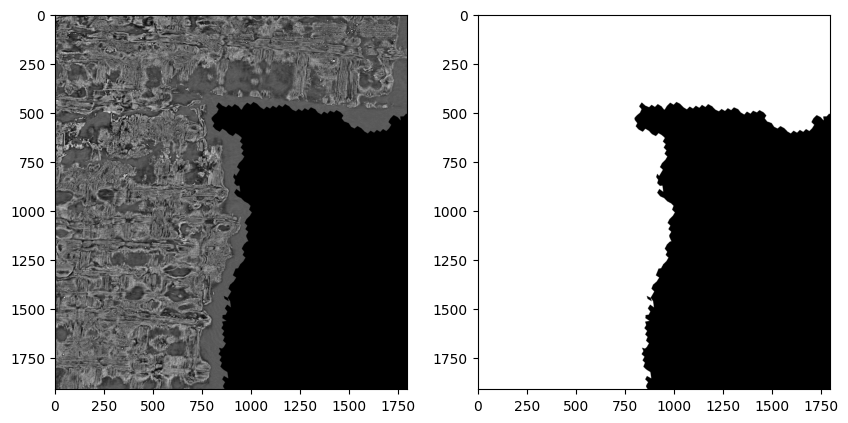

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data1['image'][..., 0], cmap='gray')
axes[1].imshow(data1['masks'][0], cmap='gray', vmin=0, vmax=1)

In [17]:
def plot_data(data):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(np.transpose(data['image'], (2, 0, 1))[..., 0], cmap='gray')
    axes[1].imshow(data['masks'][0], cmap='gray', vmin=0, vmax=1)
    axes[2].imshow(data['masks'][2], cmap='gray', vmin=0, vmax=1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(data['image'][..., 0], cmap='gray')
    axes[1].imshow(data['masks'][0], cmap='gray', vmin=0, vmax=1)
    axes[2].imshow(data['masks'][2], cmap='gray', vmin=0, vmax=1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(data['image'][..., data['image'].shape[2] // 2], cmap='gray')
    axes[1].imshow(data['masks'][0], cmap='gray', vmin=0, vmax=1)
    axes[2].imshow(data['masks'][2], cmap='gray', vmin=0, vmax=1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(data['image'][..., -1], cmap='gray')
    axes[1].imshow(data['masks'][0], cmap='gray', vmin=0, vmax=1)
    axes[2].imshow(data['masks'][2], cmap='gray', vmin=0, vmax=1)

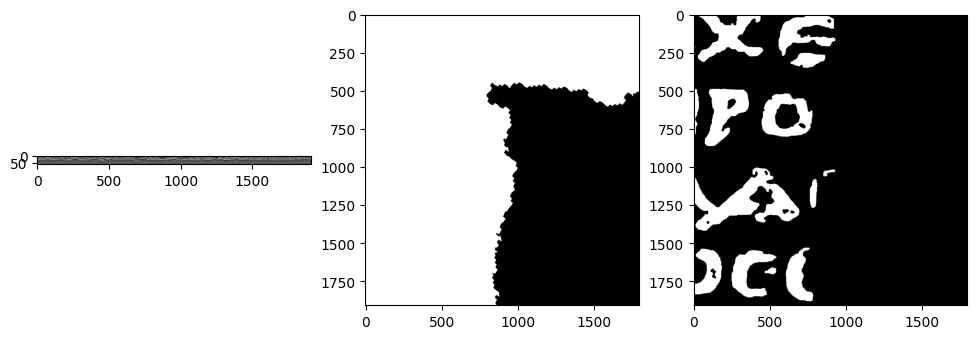

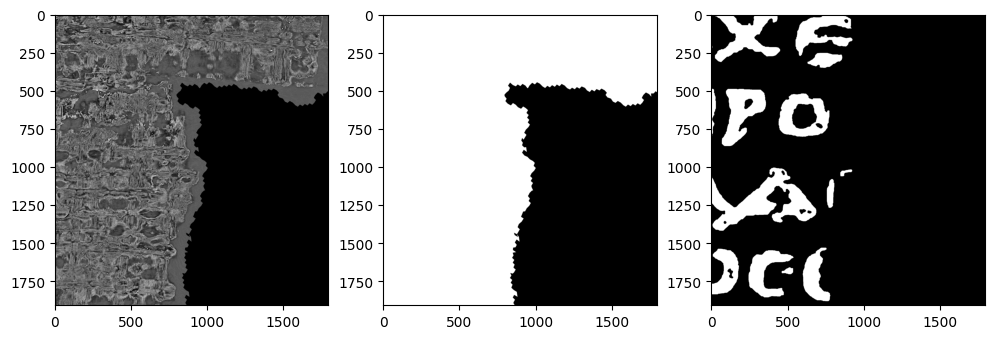

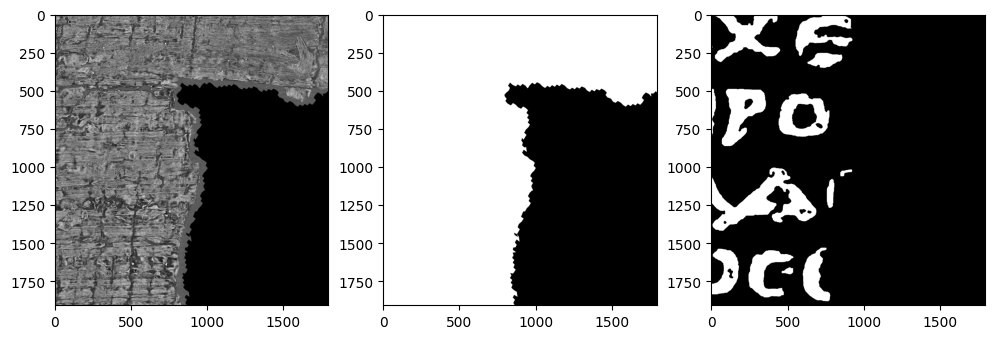

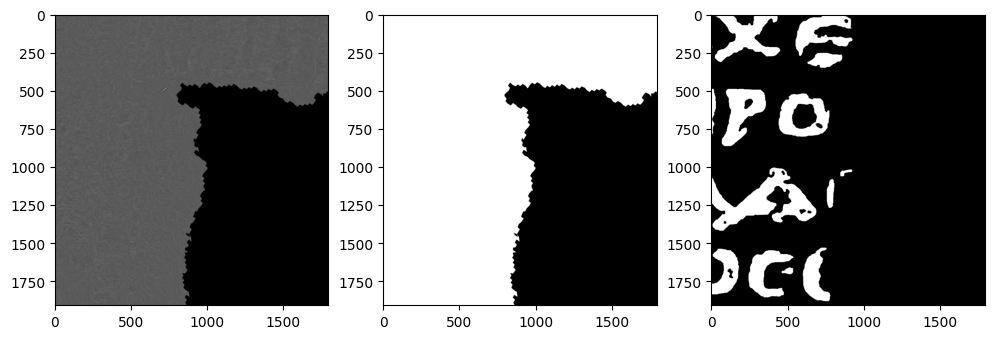

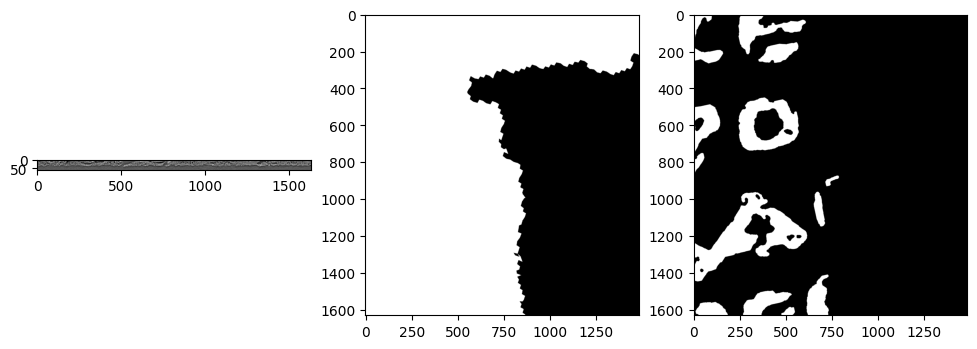

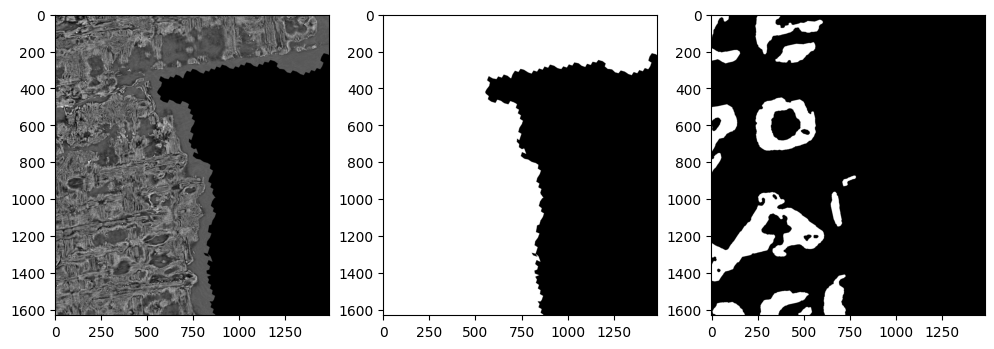

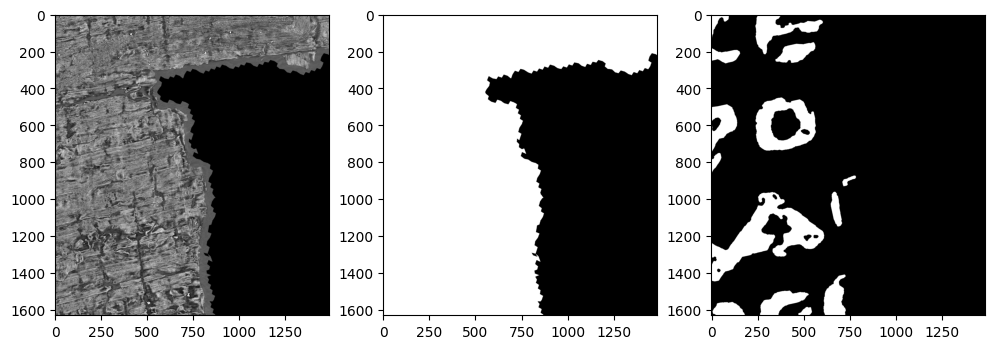

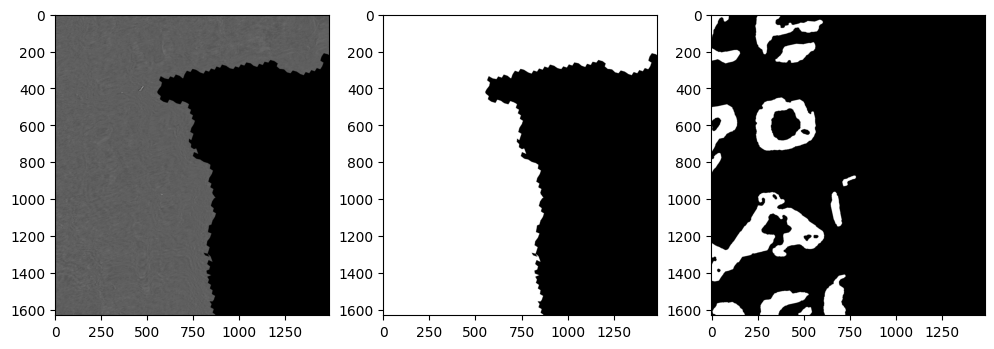

In [18]:
plot_data(data1)
data2 = transform2(**deepcopy(data1))
plot_data(data2)

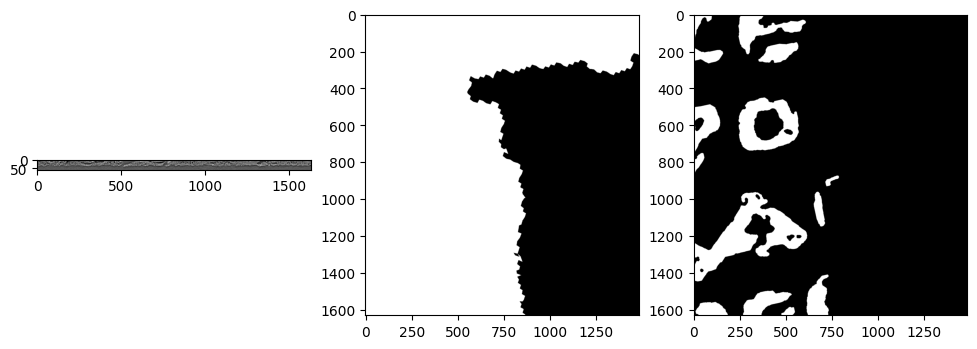

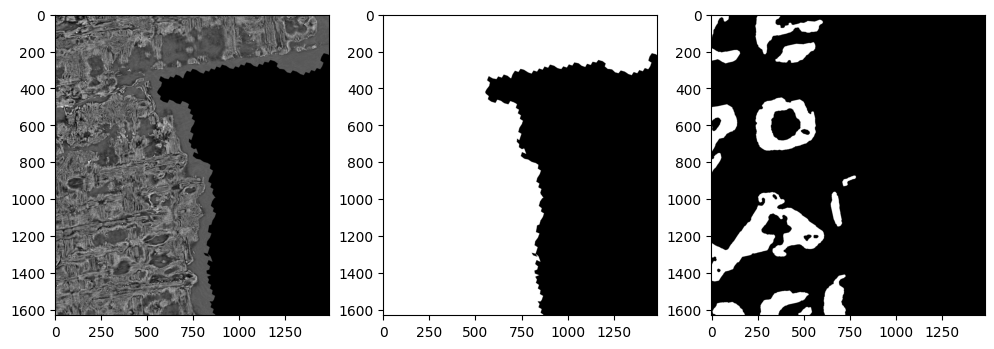

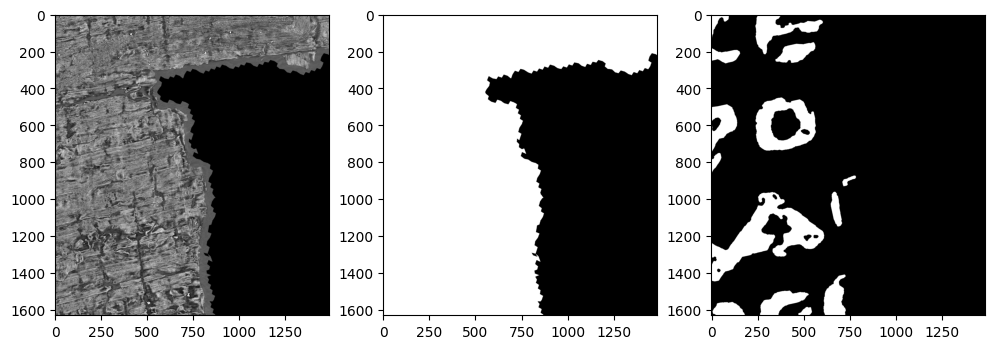

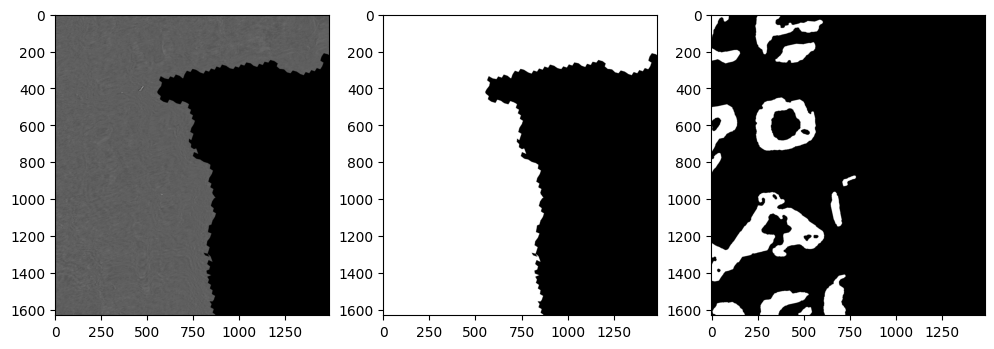

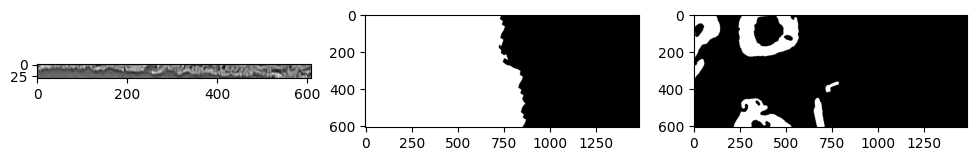

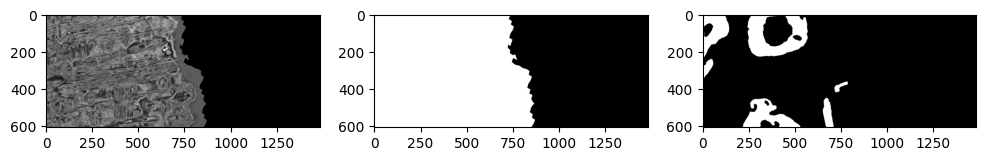

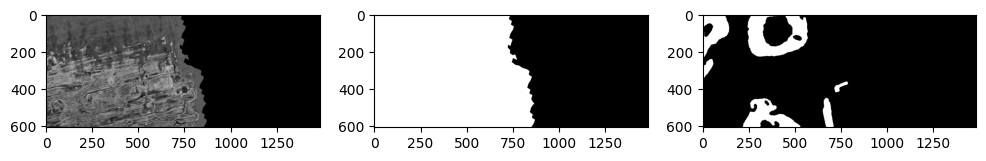

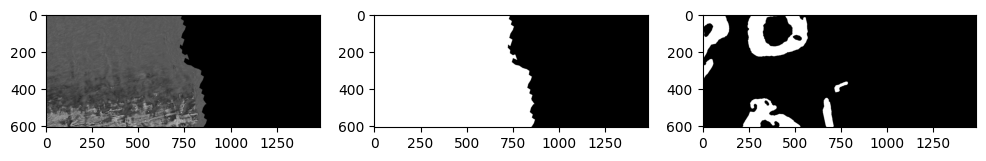

In [19]:
plot_data(data2)
data3 = transform3(**deepcopy(data2))
plot_data(data3)

### Full train transforms

$\frac{\hat{D}}{\hat{H}} = \frac{D - H \tan \alpha}{H - D \tan \alpha}$

In [23]:
def critial_angle(h, d, alpha_deg_max=45, d_hat_min=6):
    alpha = np.deg2rad(np.linspace(0, alpha_deg_max, 1000))
    d_hat = d * np.cos(alpha) - h * np.sin(alpha)
    if (d_hat < d_hat_min).all():
        return 0, []
    return alpha[d_hat >= d_hat_min][-1], d_hat

In [30]:
d = 62
h = 768
critical_angle_rad, d_hat = critial_angle(h, d, d_hat_min=56)
np.rad2deg(critical_angle_rad)

0.4054054054054054

In [35]:
d = 9
h = 768
critical_angle_rad, d_hat = critial_angle(h, d, d_hat_min=6)
np.rad2deg(critical_angle_rad)

0.18018018018018017

In [36]:
d = 9
h = 384
critical_angle_rad, d_hat = critial_angle(h, d, d_hat_min=6)
np.rad2deg(critical_angle_rad)

0.4054054054054054

In [10]:
rotate_limit_to_min_scale(45, proj=False), rotate_limit_to_min_scale(3.6, proj=True)

(1.414213562373095, 1.069248592478351)

(array([ 6.50000000e+01,  6.43961904e+01,  6.37923410e+01,  6.31884522e+01,
         6.25845243e+01,  6.19805577e+01,  6.13765528e+01,  6.07725100e+01,
         6.01684296e+01,  5.95643120e+01,  5.89601576e+01,  5.83559668e+01,
         5.77517399e+01,  5.71474773e+01,  5.65431794e+01,  5.59388465e+01,
         5.53344791e+01,  5.47300775e+01,  5.41256420e+01,  5.35211731e+01,
         5.29166711e+01,  5.23121363e+01,  5.17075693e+01,  5.11029703e+01,
         5.04983397e+01,  4.98936779e+01,  4.92889853e+01,  4.86842622e+01,
         4.80795090e+01,  4.74747260e+01,  4.68699138e+01,  4.62650726e+01,
         4.56602027e+01,  4.50553047e+01,  4.44503788e+01,  4.38454254e+01,
         4.32404450e+01,  4.26354378e+01,  4.20304042e+01,  4.14253447e+01,
         4.08202596e+01,  4.02151492e+01,  3.96100140e+01,  3.90048543e+01,
         3.83996705e+01,  3.77944629e+01,  3.71892320e+01,  3.65839781e+01,
         3.59787016e+01,  3.53734029e+01,  3.47680823e+01,  3.41627402e+01,
         3.3

In [ ]:
datamodule = SurfaceVolumeDatamodule(
    surface_volume_dirs=[
        '/workspace/data/fragments/train/1',
        '/workspace/data/fragments/train/2',
        '/workspace/data/fragments/train/3',
    ],
    surface_volume_dirs_test=None,	
    val_dir_indices=[2],
    crop_size=512,
    crop_size_z=60,
    img_size=256,
    img_size_z=64,
    batch_size=2,
    num_workers=10,
    pin_memory=False,
    prefetch_factor=2,
    persistent_workers=True,
)
datamodule.setup()

In [ ]:
dataset = datamodule.train_dataset
dataset.transform = None

In [ ]:
crop_size = datamodule.hparams.crop_size
crop_size_z = datamodule.hparams.crop_size_z
img_size = datamodule.hparams.img_size
img_size_z = datamodule.hparams.img_size_z
train_volume_mean = datamodule.train_volume_mean
train_volume_std = datamodule.train_volume_std
MAX_PIXEL_VALUE = 65536

transform1 = RandomCropVolumeInside2dMask(
    height=int(1.1 * crop_size), 
    width=int(1.1 * crop_size), 
    depth=int(1.1 * crop_size_z),
    always_apply=True,
    crop_mask_index=0,
)
transform2 = A.Compose(
    [
        ToWritable(),
        RotateX(p=0.5, limit=1, value=0, mask_value=0),
        A.Rotate(p=0.5, limit=30),
        A.RandomScale(p=0.5, scale_limit=0.1),
        CenterCropVolume(
            height=crop_size, 
            width=crop_size,
            depth=crop_size_z,
            always_apply=True,
        ),
        ResizeVolume(
            height=img_size,
            width=img_size,
            depth=img_size_z,
            always_apply=True,
        ),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
        A.Normalize(
            max_pixel_value=MAX_PIXEL_VALUE,
            mean=train_volume_mean,
            std=train_volume_std,
            always_apply=True,
        ),
        ToTensorV2(),
        ToCHWD(always_apply=True),
    ],
)

In [ ]:
data = dataset[0]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i, (name, img) in enumerate(
    zip(
        ['image', 'mask_0', 'mask_1', 'mask_2'],
        [data['image'][..., 0], *data['masks']]
    )
):
    vmin = 0
    vmax = 65536
    if name == 'image':
        vmin = -1
        vmax = 1
    elif name == 'mask_1':
        vmin = 0
        vmax = 255
    axes[i].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)

In [ ]:
data1 = transform1(**data)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i, (name, img) in enumerate(
    zip(
        ['image', 'mask_0', 'mask_1', 'mask_2'],
        [data1['image'][..., 0], *data1['masks']]
    )
):
    vmin = 0
    vmax = 1
    if name == 'image':
        vmin = 0
        vmax = 65536
    elif name == 'mask_1':
        vmin = 0
        vmax = 255
    axes[i].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)

In [ ]:
data2['masks'][0].max(), data2['masks'][0].min()

In [ ]:
data2['masks'][1].max(), data2['masks'][1].min()

In [ ]:
data2['masks'][2].max(), data2['masks'][2].min()

In [ ]:
data2 = transform2(**deepcopy(data1))
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i, (name, img) in enumerate(
    zip(
        ['image', 'mask_0', 'mask_1', 'mask_2'],
        [data2['image'][0, ..., 0], *data2['masks']]
    )
):
    vmin = 0
    vmax = 1
    if name == 'image':
        vmin = -1
        vmax = 1
    elif name == 'mask_1':
        vmin = 0
        vmax = 255
    axes[i].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)

# `OnlineSurfaceVolumeDataset`

In [30]:
train_volume_mean = sum(IMAGENET_DEFAULT_MEAN) / 3
train_volume_std = sum(IMAGENET_DEFAULT_STD) / 3
test_transform = A.Compose(
    [
        CenterCropVolume(
            height=None, 
            width=None,
            depth=9,
            strict=True,
            always_apply=True,
            p=1.0,
        ),
        ResizeVolume(
            height=384, 
            width=384,
            depth=6,
            always_apply=True,
        ),
        A.Normalize(
            max_pixel_value=MAX_PIXEL_VALUE,
            mean=train_volume_mean,
            std=train_volume_std,
            always_apply=True,
        ),
        ToTensorV2(),
        ToCHWD(always_apply=True),
    ],
)
test_dataset = OnlineSurfaceVolumeDataset(
    pathes=['/workspace/data/fragments/train/3'],
    z_start=27,
    z_end=36,
    transform=test_transform,
    patch_size=384,
    patch_step=192,
    do_z_shift_scale=True
)

In [31]:
len(test_dataset)

795

In [32]:
item = test_dataset[300]

z_shift: -1.16 1.35, z_scale: 0.98 1.07, z_start_input: 25, z_end_input: 37


In [33]:
item.keys()

dict_keys(['image', 'masks', 'path', 'indices', 'shape_patches', 'subtract', 'divide', 'shape_original', 'shape_before_padding'])

In [34]:
item['image'].shape

torch.Size([1, 384, 384, 6])

In [35]:
item['image']

tensor([[[[ 0.1698, -0.6840, -0.8738, -0.7624, -0.5221, -0.2896],
          [ 0.0525, -0.5674, -0.9705, -0.8701, -0.5698, -0.3309],
          [ 0.0711, -0.7798, -1.1393, -1.0736, -0.7558, -0.3746],
          ...,
          [ 0.6085,  0.5177,  0.1727, -0.3646, -0.7655, -0.9202],
          [ 0.6083,  0.5593,  0.2443, -0.2808, -0.6647, -0.8880],
          [ 0.6229,  0.6002,  0.3099, -0.1223, -0.5883, -0.8813]],

         [[ 0.4286, -0.1487, -0.7762, -1.0557, -0.8826, -0.5621],
          [ 0.4292, -0.1025, -0.8040, -1.1242, -0.9751, -0.6590],
          [ 0.4849, -0.1064, -0.8400, -1.1912, -1.0572, -0.7080],
          ...,
          [ 0.4688,  0.4675,  0.2087, -0.2700, -0.6758, -0.8580],
          [ 0.4898,  0.5439,  0.3523, -0.1028, -0.5702, -0.8436],
          [ 0.5665,  0.6273,  0.4592, -0.0187, -0.5598, -0.8678]],

         [[ 0.4822, -0.1017, -0.7701, -1.0823, -0.9043, -0.6146],
          [ 0.4866, -0.0221, -0.8626, -1.1252, -0.9911, -0.6486],
          [ 0.4797, -0.1380, -0.8337, -1.1